<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/open3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

179


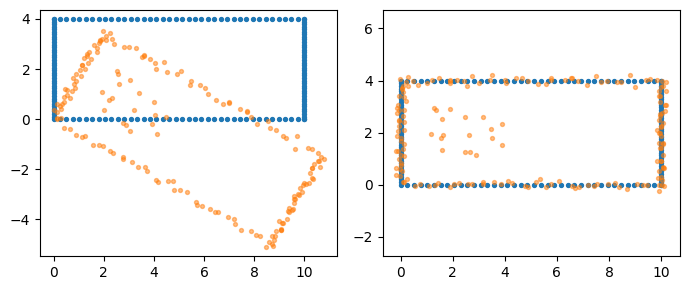

True: dx: 0.00, dy: 0.00, angle: 30.0°
Found: dx: -0.02, dy: -0.03, angle: 29.4°


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

DX, DY = 0, 0
ANGLE = np.radians(30)
NOISE_LEVEL = 0.1
NUM_POINTS = 40
NUM_OBSTACLES = 20
ITERS = 40

def icp(src, tgt):
    tree = KDTree(tgt)
    R, t = np.eye(2), np.zeros(2)
    for _ in range(ITERS):
        tr = src @ R.T + t
        idx = tree.query(tr)[1]
        src_m, tgt_m = tr.mean(0), tgt[idx].mean(0)
        H = (tr - src_m).T @ (tgt[idx] - tgt_m)
        U, _, Vt = np.linalg.svd(H)
        R_new = Vt.T @ U.T
        t_new = tgt_m - R_new @ src_m
        R, t = R_new @ R, R_new @ t + t_new
    return [t[0], t[1], np.arctan2(R[1,0], R[0,0])]

v = np.array([[0,0],[0,4],[10,4],[10,0]])
points = np.vstack([v[i]+t*(v[(i+1)%len(v)]-v[i]) for i in range(len(v)) for t in np.linspace(0,1,NUM_POINTS)])[:-1]

R = [[np.cos(ANGLE), -np.sin(ANGLE)], [np.sin(ANGLE), np.cos(ANGLE)]]
points2 = points @ R + [DX, DY] + np.random.randn(*points.shape) * NOISE_LEVEL
obstacles = np.random.uniform(1, 4, (NUM_OBSTACLES, 2)) @ R + [DX, DY]
points2 = np.vstack([points2, obstacles])
print(len(points2))
dx, dy, da = icp(points, points2)

plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.scatter(points[:,0], points[:,1], s=8)
plt.scatter(points2[:,0], points2[:,1], s=8, alpha=0.5)
plt.axis('equal')

plt.subplot(1,2,2)
R_found = [[np.cos(da), -np.sin(da)], [np.sin(da), np.cos(da)]]
aligned = (points2 - [dx,dy]) @ R_found
plt.scatter(points[:,0], points[:,1], s=8)
plt.scatter(aligned[:,0], aligned[:,1], s=8, alpha=0.5)
plt.axis('equal')

plt.tight_layout()
plt.show()

print(f"True: dx: {DX:.2f}, dy: {DY:.2f}, angle: {np.degrees(ANGLE):.1f}°")
print(f"Found: dx: {dx:.2f}, dy: {dy:.2f}, angle: {-np.degrees(da):.1f}°")

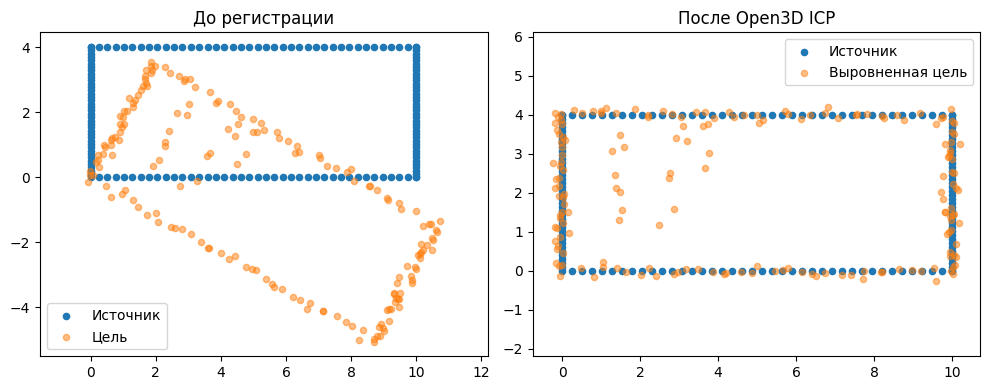

True: dx: 0.00, dy: 0.00, angle: 30.0°
Found: dx: 0.02, dy: -0.08, angle: 29.3°
Fitness: 1.0000, RMSE: 0.1081


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# Параметры
DX, DY = 0, 0
ANGLE = np.radians(30)
NOISE_LEVEL = 0.1
NUM_POINTS = 40
NUM_OBSTACLES = 20

# Создание точек
v = np.array([[0,0],[0,4],[10,4],[10,0]])
points = np.vstack([v[i]+t*(v[(i+1)%len(v)]-v[i]) for i in range(len(v)) for t in np.linspace(0,1,NUM_POINTS)])[:-1]

# Преобразование
R = [[np.cos(ANGLE), -np.sin(ANGLE)], [np.sin(ANGLE), np.cos(ANGLE)]]
points2 = points @ R + [DX, DY] + np.random.randn(*points.shape) * NOISE_LEVEL
obstacles = np.random.uniform(1, 4, (NUM_OBSTACLES, 2)) @ R + [DX, DY]
points2 = np.vstack([points2, obstacles])

# Преобразование в 3D
source_3d = np.hstack([points, np.zeros((points.shape[0], 1))])
target_3d = np.hstack([points2, np.zeros((points2.shape[0], 1))])

# Open3D облака точек
source_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(source_3d))
target_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(target_3d))

# ICP регистрация
trans_init = np.eye(4)
reg_result = o3d.pipelines.registration.registration_icp(
    source_pcd, target_pcd, 1.0, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=40)
)

# Применение преобразования
transformation = reg_result.transformation
target_aligned = target_pcd.transform(np.linalg.inv(transformation))

# Извлечение параметров
dx = transformation[0, 3]
dy = transformation[1, 3]
da = np.arctan2(transformation[1, 0], transformation[0, 0])

# 2D визуализация
plt.figure(figsize=(10, 4))

# До регистрации
plt.subplot(1, 2, 1)
plt.scatter(points[:,0], points[:,1], s=20, label='Источник')
plt.scatter(points2[:,0], points2[:,1], s=20, alpha=0.5, label='Цель')
plt.title('До регистрации')
plt.legend()
plt.axis('equal')

# После регистрации
plt.subplot(1, 2, 2)
aligned_2d = np.asarray(target_aligned.points)[:, :2]
plt.scatter(points[:,0], points[:,1], s=20, label='Источник')
plt.scatter(aligned_2d[:,0], aligned_2d[:,1], s=20, alpha=0.5, label='Выровненная цель')
plt.title('После Open3D ICP')
plt.legend()
plt.axis('equal')

plt.tight_layout()
plt.show()

print(f"True: dx: {DX:.2f}, dy: {DY:.2f}, angle: {np.degrees(ANGLE):.1f}°")
print(f"Found: dx: {dx:.2f}, dy: {dy:.2f}, angle: {-np.degrees(da):.1f}°")
print(f"Fitness: {reg_result.fitness:.4f}, RMSE: {reg_result.inlier_rmse:.4f}")